# QUEST Datathon 2021<a class="anchor" id="top"></a>
## Hack Islamophobia

Varun Singhai, Asher Gilani, Daniel Ben-Or<br>


## Table of Contents

1. [Introduction](#Introduction) <br>
2. [Data Wrangling](#2) <br>
    2.1 [Imports](#2.1) <br>
    2.2 [Loading in the Data](#2.2) <br>
    2.3 [Tidy Data](#2.3) <br>
3. [Data Exploration](#3) <br>
    3.1 [Plotting](#3.1) <br>
    3.2 [Verified Users](#3.2) <br>
    3.3 [Retweet Distribution](#3.3) <br>
    3.4 [Time Distribution of Tweets](#3.4) <br>
    3.5 [Initial Conclusions](#3.5) <br>
4. [Word Cloud](#4) <br>
5. [Penetration Network](#5) <br>
    5.1 [Generating Mentions Column](#5.1) <br>
    5.2 [Aggregating Users + Preparing Network](#5.2)<br>
    5.3 [Creating Network](#5.3) <br>
    5.4 [Actionable Insights](#5.4) <br>
6. [Sentiment Analysis](#6) <br>
    6.1 [Sentiment Intensity Column](#6.1) <br>
    6.2 [Showcase Best/Worse Tweets](#6.2) <br>
    6.3 [Plotting Sentiment Distribution](#6.3) <br>
7. [Hashtag Bar Chart Race](#7) <br>
    7.1 [Distribution of tweets](#7.1) <br>
    7.2 [Video](#7.2) <br>
8. [Live Tweet Flagging](#8)<br>
    8.1 [Classification](#8.1)<br>
    8.2 [Live Tweets](#8.2) <br>
9. [Twitter Heatmap](#9)<br>
    9.1 [Dot Map](#9.1)<br>
    9.2 [Heat Map](#9.2)<br>
10. [Conclusion](#10) <br>

<a id=Introduction></a>
## 1. Introduction

<a id=2></a>
## 2. Data Wrangling

I want to figure out where Islamaphobic tweets are originating from (which tweets, users, etc) as well as what factors contribute to responses to these tweets.

The given dataset comes with  a lot of excess columns so I will try to extract the relevant data.

<a id=2.1></a>
### 2.1 Imports

In [1]:
import pandas as pd
import statsmodels as sm
from collections import defaultdict, Counter
import json

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import seaborn as sns; sns.set()

import networkx as nx
from pyvis.network import Network

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
nltk.download('punkt'); nltk.download('stopwords')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud

import datetime
from tqdm import tqdm
import bar_chart_race as bcr

import twint

import folium
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asher\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asher\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id=2.2></a>
### 2.2 Loading in the Data

In [2]:
df_50k = pd.read_csv('./noislamophobia-dataset-50k.csv')
df_75k = pd.read_csv('./noislamophobia-dataset-75k.csv')
df = pd.concat([df_50k,df_75k])
df.head()

c:\users\asher\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2,8,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,_id,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,...,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,full_text,truncated,user,withheld_in_countries
0,ObjectId(59dbede4e6e465a2d67a1062),NaN,NaN,Sun Oct 22 10:34:06 +0000 2017,"{""hashtags"":[{""text"":""BanIslam"",""indices"":[93,...",NaN,0,False,NaN,9.220484e+17,...,NaN,4,False,"{""created_at"":""Fri Oct 20 09:33:45 +0000 2017""...","<a href=""http://twitter.com/download/iphone"" r...",RT @Private34349909: @AmyMek @Dab7One 1/ @real...,NaN,False,"{""id"":8.009259051368776e+17,""id_str"":""80092590...",NaN
1,ObjectId(59dbede4e6e465a2d67a106c),NaN,NaN,Sun Oct 22 10:13:40 +0000 2017,"{""hashtags"":[{""text"":""muslim"",""indices"":[16,23...",NaN,0,False,NaN,9.220433e+17,...,NaN,10,False,"{""created_at"":""Sat Oct 21 18:37:07 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @ensine: All #muslim rulers were savages bc...,NaN,False,"{""id"":375089876,""id_str"":""375089876"",""name"":""द...",NaN
2,ObjectId(59dbf266e6e465a2d67a4810),NaN,NaN,Sun Oct 22 07:50:47 +0000 2017,"{""hashtags"":[{""text"":""Raqqa"",""indices"":[37,43]...",NaN,0,False,NaN,9.220073e+17,...,NaN,172,False,"{""created_at"":""Fri Oct 20 23:15:45 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @SLandinSoCal: Liberated Women of #Raqqa‼️R...,NaN,False,"{""id"":7.092975641898926e+17,""id_str"":""70929756...",NaN
3,ObjectId(59dbf266e6e465a2d67a4828),NaN,NaN,Sun Oct 22 10:38:23 +0000 2017,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{...",NaN,0,False,NaN,9.220495e+17,...,NaN,1,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@Stormtroepen @cdavandaag @sybrandbuma @gertja...,NaN,True,"{""id"":1340408646,""id_str"":""1340408646"",""name"":...",NaN
4,ObjectId(59e8e630e6e465a2d6238c9c),NaN,NaN,Sun Oct 22 08:59:53 +0000 2017,"{""hashtags"":[{""text"":""RT"",""indices"":[51,54]},{...",NaN,0,False,NaN,9.220247e+17,...,NaN,25,False,"{""created_at"":""Sun Oct 22 01:40:55 +0000 2017""...","<a href=""http://twitter.com/download/android"" ...",RT @PoliticalIslam: Sharia at odds with Articl...,NaN,False,"{""id"":150595824,""id_str"":""150595824"",""name"":""🇮...","[""DE""]"


In [3]:
df.in_reply_to_screen_name.notna().sum()

12162

<a id=2.3></a>
### 2.3 Tidy Data

In [4]:
# Get a username column
df.user[0]

0    {"id":8.009259051368776e+17,"id_str":"80092590...
0    {"id":8.009259051368776e+17,"id_str":"80092590...
Name: user, dtype: object

In [5]:
origin = df[['user', 'in_reply_to_screen_name', 'retweet_count', 'retweeted', 'created_at', 'text']]
origin.head()

,user,in_reply_to_screen_name,retweet_count,retweeted,created_at,text
0,"{""id"":8.009259051368776e+17,""id_str"":""80092590...",NaN,4,False,Sun Oct 22 10:34:06 +0000 2017,RT @Private34349909: @AmyMek @Dab7One 1/ @real...
1,"{""id"":375089876,""id_str"":""375089876"",""name"":""द...",NaN,10,False,Sun Oct 22 10:13:40 +0000 2017,RT @ensine: All #muslim rulers were savages bc...
2,"{""id"":7.092975641898926e+17,""id_str"":""70929756...",NaN,172,False,Sun Oct 22 07:50:47 +0000 2017,RT @SLandinSoCal: Liberated Women of #Raqqa‼️R...
3,"{""id"":1340408646,""id_str"":""1340408646"",""name"":...",Stormtroepen,1,False,Sun Oct 22 10:38:23 +0000 2017,@Stormtroepen @cdavandaag @sybrandbuma @gertja...
4,"{""id"":150595824,""id_str"":""150595824"",""name"":""🇮...",NaN,25,False,Sun Oct 22 08:59:53 +0000 2017,RT @PoliticalIslam: Sharia at odds with Articl...


In [6]:
# want to get username, user_id_str, followers_count, verified out of 'user'
user_df = origin.user.apply(json.loads).apply(pd.Series)
user_df.head()

,id,id_str,name,screen_name,location,description,url,entities,protected,followers_count,...,profile_text_color,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,following,follow_request_sent,notifications,translator_type,withheld_in_countries
0,8.009259e+17,800925905136877569,Cl_USARocks 🇺🇸,usarocks_c,United States,Grateful 4 Trump fam! Support Trump 100%! Than...,https://t.co/LiQOFDfZgS,{'url': {'urls': [{'url': 'https://t.co/LiQOFD...,False,10789,...,333333,True,False,True,False,False,False,False,none,NaN
1,3.750899e+08,375089876,दिनेश कुमार सिंह,vanrash02chahat,बिलासपुर छत्तीसगढ़,,None,{'description': {'urls': []}},False,292,...,333333,True,False,False,False,False,False,False,none,NaN
2,7.092976e+17,709297564189892608,CanadianDeplorable,gtstuart1,"British Columbia, Canada","Little Wonder, You little Wonder You",None,{'description': {'urls': []}},False,154,...,333333,True,False,True,False,False,False,False,none,NaN
3,1.340409e+09,1340408646,Hannesz,Hannesz1956,Nederland,Hannesz. Oud-journo. Het Nieuws van 1 Kant. An...,https://t.co/MkLnSMT8PF,{'url': {'urls': [{'url': 'https://t.co/MkLnSM...,False,7010,...,5E412F,True,False,False,False,False,False,False,none,NaN
4,1.505958e+08,150595824,🇮🇱ReasonPrevail🇺🇸🇫🇷,ReasonPrevail,US of A,Exposing MEDIA bias & PaLIEstinian propaganda....,https://t.co/LlpRv4hPMT,{'url': {'urls': [{'url': 'https://t.co/LlpRv4...,False,359,...,333333,True,False,False,False,False,False,False,none,NaN


In [7]:
origin['id_str'] = user_df.id_str.copy()
origin['username'] = user_df.screen_name.copy()
origin['followers_count'] = user_df.followers_count.copy()
origin['verified'] = user_df.verified.copy()
origin = origin[['username', 'id_str', 'followers_count', 'verified', 'in_reply_to_screen_name', 'retweet_count', 'retweeted', 'text', 'created_at']]
origin.head()

c:\users\asher\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\asher\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\asher\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at
0,usarocks_c,800925905136877569,10789,False,NaN,4,False,RT @Private34349909: @AmyMek @Dab7One 1/ @real...,Sun Oct 22 10:34:06 +0000 2017
1,vanrash02chahat,375089876,292,False,NaN,10,False,RT @ensine: All #muslim rulers were savages bc...,Sun Oct 22 10:13:40 +0000 2017
2,gtstuart1,709297564189892608,154,False,NaN,172,False,RT @SLandinSoCal: Liberated Women of #Raqqa‼️R...,Sun Oct 22 07:50:47 +0000 2017
3,Hannesz1956,1340408646,7010,False,Stormtroepen,1,False,@Stormtroepen @cdavandaag @sybrandbuma @gertja...,Sun Oct 22 10:38:23 +0000 2017
4,ReasonPrevail,150595824,359,False,NaN,25,False,RT @PoliticalIslam: Sharia at odds with Articl...,Sun Oct 22 08:59:53 +0000 2017


In [8]:
# The retweeted column is always false, so recalculate it
origin.retweeted = origin.text.str.startswith('RT')
print(f'Number of tweets that are RTs: {origin.retweeted.sum()}')

# created_at column is not of type datetime
origin.created_at = pd.to_datetime(origin.created_at)

origin[origin.retweeted].head()

Number of tweets that are RTs: 95890


,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at
0,usarocks_c,800925905136877569,10789,False,NaN,4,True,RT @Private34349909: @AmyMek @Dab7One 1/ @real...,2017-10-22 10:34:06+00:00
1,vanrash02chahat,375089876,292,False,NaN,10,True,RT @ensine: All #muslim rulers were savages bc...,2017-10-22 10:13:40+00:00
2,gtstuart1,709297564189892608,154,False,NaN,172,True,RT @SLandinSoCal: Liberated Women of #Raqqa‼️R...,2017-10-22 07:50:47+00:00
4,ReasonPrevail,150595824,359,False,NaN,25,True,RT @PoliticalIslam: Sharia at odds with Articl...,2017-10-22 08:59:53+00:00
5,NattieNexit,700721268354641920,546,False,NaN,2,True,RT @Hannesz1956: @Stormtroepen @NattieNexit @d...,2017-10-22 10:51:17+00:00


<a id=3></a>
## 3. Data Exploration
I now have the dataframe origin which has the username and some potential measures for how popular the user is and how much "penetration potential" their tweets have.

Will now begin to explore the data.

<a id=3.1></a>
### 3.1 Plotting

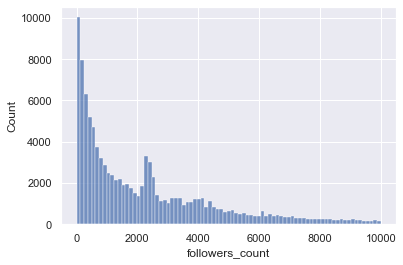

In [9]:
sns.histplot(data=origin, x='followers_count', binrange=(0, 10000))

<a id=3.2></a>
### 3.2 Verified Users

In [10]:
origin[origin.verified].head()

,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at
1358,LauraLoomer,537709549,105475,True,NaN,28,False,They deserve it. Maybe when they all decide to...,2017-11-01 06:43:34+00:00
13733,peterboykin,24493104,57752,True,NaN,2167,True,RT @OneVoiceUS: RT if you want to put #America...,2018-03-16 03:15:29+00:00
14808,WorldofIsaac,57328888,29603,True,NaN,0,False,"In this guy's profile\n\n""West Michigander, na...",2018-03-30 03:52:18+00:00
14818,peterboykin,24493104,58888,True,NaN,93,True,RT @dodt2003: Although we’ve been distracted l...,2018-03-30 08:11:54+00:00
15592,JessieJaneDuff,478855762,137642,True,NaN,36,True,"RT @OldManStoneZone: Ok America, this little v...",2018-04-11 14:52:35+00:00


<a id=3.3></a>
### 3.3 Retweet Distribution

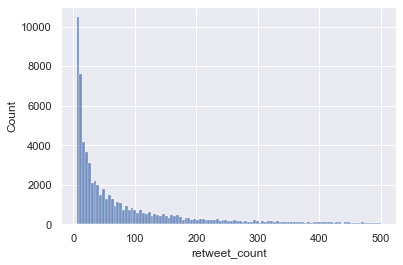

In [11]:
# I excludes tweets with < 5 retweets since they are a clear majority and mess up the scale of the graph
sns.histplot(data=origin, x='retweet_count', binrange=(5, 500))

<a id=3.4></a>
### 3.4 Time Distribution of Tweets

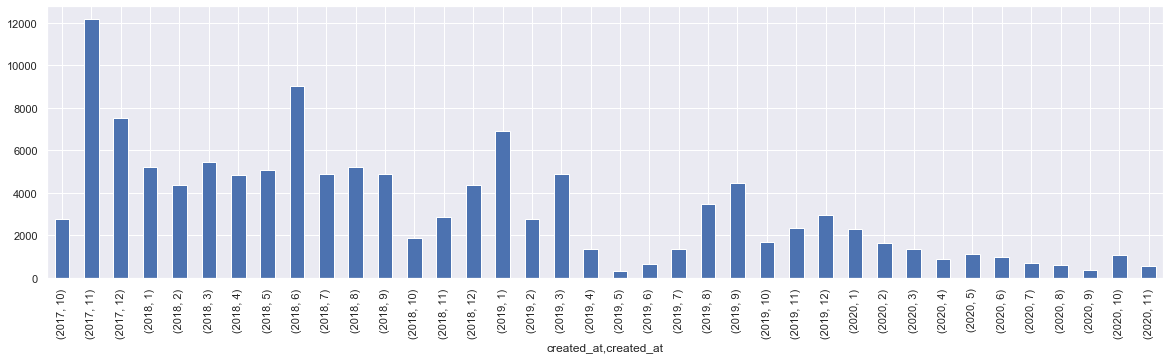

In [12]:
origin.groupby([origin.created_at.dt.year, origin.created_at.dt.month])['username'].count().plot(kind='bar', figsize=(20, 5))

<a id=3.5></a>
### 3.5 Initial Conclusions
- Most of the people tweeting in this dataset have very few followers. The distribution of followers is highest at 0 with an exponential dropoff for larger amounts of followers.
- There are very few verified users (around 28). These users obviously have a high amount of followers compared to other users.
- These verified users are retweeted a lot. The retweet_count distribution has an exponential dropoff and all of these verified users have retweet_counts much higher than shown in the retweet_count histogram.
- Verified users also retweet others a lot. This was not properly indicated in the retweeted column, so I recalculated it.
- Most of our tweets come from late 2017 - 2018 with fewer tweets in 2019 and 2020. November 2017 had a particularly high amount of tweets. Likely due to [this attempted bombing](https://en.m.wikipedia.org/wiki/2017_New_York_City_attempted_bombing).

<a id=4></a>
## 4 Word Cloud
Show which words are the most popular to get a general idea of what people are tweeting about.

In [13]:
# Filter out words that start with things in filter_list or any stopwords
filter_list = ['@', '#', 'http', 'rt', '&', 'islam', 'muslim', 'religion', 'don', 'need', 'know']
stops = set(stopwords.words('english'))

def good_wd(wd):
    return not any(wd.lower().startswith(x) for x in filter_list) and wd not in stops

# Clean up tweets
tweets = df.text.dropna().str.split().apply(lambda lst: ' '.join(filter(good_wd, lst)))

# Generate word cloud
wordcloud = WordCloud().generate(' '.join(tweets))
image = wordcloud.to_image()
#image.save('wordcloud.png')

![wordcloud](./wordcloud.png)

<a id=5></a>
## 5. Penetration Network
At this point, it seems clear that verified users have much higher Twitter penetration since they are much more involved in the process of retweeting as well as being retweeted. There are not many verified users in this dataset so I will also be looking at users with a high amount of followers. I will try to visualize how tweets from these users spread and what factors influence this spread.

<a id=5.1></a>
### 5.1 Generating Mentions Column

In [14]:
# Get a column that has all the @'d users for that tweet
origin['mentions'] = origin.text.str.split().apply(lambda lst: [(x[1:-1] if x.endswith(':') else x[1:]) for x in filter(lambda x: x.startswith('@'), lst)])
origin.head()

,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at,mentions
0,usarocks_c,800925905136877569,10789,False,NaN,4,True,RT @Private34349909: @AmyMek @Dab7One 1/ @real...,2017-10-22 10:34:06+00:00,"[Private34349909, AmyMek, Dab7One, realDonaldT..."
1,vanrash02chahat,375089876,292,False,NaN,10,True,RT @ensine: All #muslim rulers were savages bc...,2017-10-22 10:13:40+00:00,[ensine]
2,gtstuart1,709297564189892608,154,False,NaN,172,True,RT @SLandinSoCal: Liberated Women of #Raqqa‼️R...,2017-10-22 07:50:47+00:00,[SLandinSoCal]
3,Hannesz1956,1340408646,7010,False,Stormtroepen,1,False,@Stormtroepen @cdavandaag @sybrandbuma @gertja...,2017-10-22 10:38:23+00:00,"[Stormtroepen, cdavandaag, sybrandbuma, gertja..."
4,ReasonPrevail,150595824,359,False,NaN,25,True,RT @PoliticalIslam: Sharia at odds with Articl...,2017-10-22 08:59:53+00:00,[PoliticalIslam]


<a id=5.2></a>
### 5.2 Aggregating Users + Preparing Network

In [15]:
cols = ['username', 'followers_count', 'retweet_count', 'mentions']

# Aggregate users to count their average num of followers, total retweets, and total mentions
graph_df = origin[cols].groupby('username').agg({'followers_count': 'mean', 'retweet_count': 'sum', 'mentions': 'sum'}).reset_index()

# Will use follower count to represent node size; scale them between sizes [1000, 51000] for the network
graph_df['scaled_count'] = 1000 + (graph_df.followers_count - graph_df.followers_count.min()) * 50000 / (graph_df.followers_count.max() - graph_df.followers_count.min())

# Explode df on mentions to add in edges
graph_df = graph_df.explode('mentions')

# Add underscore to usernames and mentions so they aren't treated as ints by the library
graph_df.username = graph_df.username + '_'
graph_df.mentions = graph_df.mentions + '_'

# Calculate hex color codes so that higher retweet count corresponds to darker red node
norm = Normalize(vmin=0, vmax=5000, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Reds)
graph_df['colors'] = graph_df.retweet_count.apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))

graph_df.head()

,username,followers_count,retweet_count,mentions,scaled_count,colors
0,0000DD02_,2784.5,16,traybishop_,1141.797923,#fff5f0
0,0000DD02_,2784.5,16,RealDrGina_,1141.797923,#fff5f0
0,0000DD02_,2784.5,16,76rooster_,1141.797923,#fff5f0
1,000_Gopal32_,2574.5,248,TharkiBaba01_,1131.103880,#ffede5
1,000_Gopal32_,2574.5,248,Donotshit_,1131.103880,#ffede5


<a id=5.3></a>
### 5.3 Creating Network

In [16]:
# More red = More retweets, Larger = More followers
nodes = graph_df.head(500).drop_duplicates('username')
mentions = [x for x in graph_df.head(500).mentions.dropna() if x not in nodes.username]
title_col = 'Followers: ' + nodes.followers_count.astype(int).astype(str) + '\nRetweets: ' + nodes.retweet_count.astype(str)

nt = Network(height=800, width='100%', notebook=True, directed=True)
nt.add_nodes(nodes.username.to_numpy(), title=title_col, value=nodes.scaled_count, color=nodes.colors)
nt.add_nodes(mentions, title=mentions, value=[50] * len(mentions), color=['#FFFFFF'] * len(mentions))
nt.add_edges(graph_df[['username', 'mentions']].head(500).dropna().to_records(index=False))

nt.show('pen_network.html')

<a id=5.4></a>
### 5.4 Actionable Insights
- This graph makes it easy to identify the highest "penetration" users, the users whose tweets have the most influence. Twitter could use this data to just ban users who are spreading too much Islamophobic sentiment to quickly mitigate the spread.
- This graph also reveals the hidden structures in our data which is the relationship between different users. Activists could focus their efforts on these central node users since they have the highest potential of spreading positive messages out to their connected group.
- This enables graph algorithms such as page rank or shortest path algorithms. These could be used to identify the most toxic users or to estimate how long news or Islamophobic will spread through a network.

<a id=6></a>
## 6. Sentiment Analysis
I will be using the VADER Sentiment Analysis library since it works well on emojis and slang. This library also uses NLTK under the hood for parsing out stop words. This will generate a score for each tweet from -1 to 1.
- Score < -0.05: Negative Sentiment
- Score > 0.05: Positive Sentiment
- -0.05 <= Score <= 0.05: Neutral Sentiment

<a id=6.1></a>
### 6.1 Sentiment Intensity Column

In [17]:
sent = SentimentIntensityAnalyzer()
origin['sentiment'] = origin.text.apply(lambda s: sent.polarity_scores(s)['compound'])
origin.head()

,username,id_str,followers_count,verified,in_reply_to_screen_name,retweet_count,retweeted,text,created_at,mentions,sentiment
0,usarocks_c,800925905136877569,10789,False,NaN,4,True,RT @Private34349909: @AmyMek @Dab7One 1/ @real...,2017-10-22 10:34:06+00:00,"[Private34349909, AmyMek, Dab7One, realDonaldT...",0.4648
1,vanrash02chahat,375089876,292,False,NaN,10,True,RT @ensine: All #muslim rulers were savages bc...,2017-10-22 10:13:40+00:00,[ensine],-0.5267
2,gtstuart1,709297564189892608,154,False,NaN,172,True,RT @SLandinSoCal: Liberated Women of #Raqqa‼️R...,2017-10-22 07:50:47+00:00,[SLandinSoCal],0.0000
3,Hannesz1956,1340408646,7010,False,Stormtroepen,1,False,@Stormtroepen @cdavandaag @sybrandbuma @gertja...,2017-10-22 10:38:23+00:00,"[Stormtroepen, cdavandaag, sybrandbuma, gertja...",0.2960
4,ReasonPrevail,150595824,359,False,NaN,25,True,RT @PoliticalIslam: Sharia at odds with Articl...,2017-10-22 08:59:53+00:00,[PoliticalIslam],0.0000


<a id=6.2></a>
### 6.2 Showcase Best/Worse Tweets

In [18]:
# Five worst sentiment tweets
list(origin.sort_values('sentiment').text[:5])

['@potus WE HAVE A #terrorism problem \nAmerica will NEVER submit to 🚫#Islam \n😠😠😠😠😠😠😠😠😠😠😠 @ICEgov @SecretService @FBI… https://t.co/LTzitgKuJk',
 '@lsarsour Explain why Islam also promotes animal abuse?!? #BanSharia #BanIslam #BanLindaSarsour \n😠😠😠😠😠😠😠😠😠😠😠😠\nhttps://t.co/L7yLwvQopf',
 '#Sweden :  #Girl #gang #raped , #VAGINA SET ON #FIRE 😠😠😠😠😠😠😠😠\n#EnoughIsEnough \nSTOP #rapeculture\nSTOP #CARNAGE… https://t.co/Lax7gOkkze',
 'RT @Chris_A10_USA: #Ireland 🇮🇪: #Muslim #migrant charged in random #stabbing #murder, Gardai still say no link to #terrorism 😠😠😠😠😠\n#BanShar…',
 'RT @Chris_A10_USA: #Ireland 🇮🇪: #Muslim #migrant charged in random #stabbing #murder, Gardai still say no link to #terrorism 😠😠😠😠😠\n#BanShar…']

In [19]:
# Five best sentiment tweets
list(origin.sort_values('sentiment', ascending=False).text[:5])

['😂 😂😂 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂\n#Banislam #MAGA\nhttps://t.co/Nyo1aLf9Ka',
 'Goodnight friends \n🇳🇱🇳🇱🇳🇱🇳🇱🇳🇱🇳🇱🇳🇱\n♥️♥️♥️♥️♥️♥️♥️\n🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸\n♥️♥️♥️♥️♥️♥️♥️\n#Trump \n#TrumpLandslide2020… https://t.co/w7k752m9Dj',
 '@WindowFixed @Ilhan 🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣\nWhere are all the moderates\nwhen you need them!\n\nMuslim women, children, &amp; gays\nbein… https://t.co/V8U2TRBfSp',
 'RT @BoondockCat: @WindowFixed @Ilhan 🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣\nWhere are all the moderates\nwhen you need them!\n\nMuslim women, children, &amp; gays\nbeing raped…',
 'RT @n_gaged: @FearThouNot @lbc360 but, but they keep telling us that Islam is the religion(sic) of peace.🤫😂😂🤣🤣😂😂😡 #BanIslamQuranCitizenship…']

In [20]:
# Five tweets with most neutral sentiment
list(origin.sort_values('sentiment', key=abs).text[:5])

['@kelly_syra @RealMAGASteve @RosieAndujar @sxdoc @starcrosswolf @Dr_Kaco @Stump_for_Trump @TrumpTrainMRA4… https://t.co/fnFezUy9ld',
 'RT @RevolutieNL: Kerken in Urk op slot vanwege oproepen tot aanslagen vanuit de moslimgemeenschap.\n\nDaarom #BanIslam\nhttps://t.co/mOAjapv07S',
 'RT @RevolutieNL: Kerken in Urk op slot vanwege oproepen tot aanslagen vanuit de moslimgemeenschap.\n\nDaarom #BanIslam\nhttps://t.co/mOAjapv07S',
 'RT @RevolutieNL: Kerken in Urk op slot vanwege oproepen tot aanslagen vanuit de moslimgemeenschap.\n\nDaarom #BanIslam\nhttps://t.co/mOAjapv07S',
 'RT @jodaka97: WAKE UP AMERICA! Mu$1ims cannot be allowed to take office!  There are over 90 of them running for office across the US.  They…']

<a id=6.3></a>
### 6.3 Plotting Sentiment Distribution

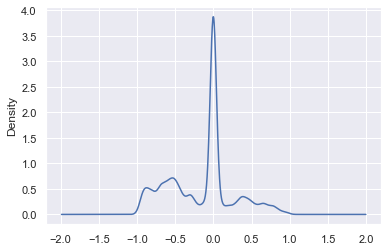

In [21]:
origin.sentiment.plot.kde()

This sentiment analysis is not perfect. It definitely does a better job detecting meaner tweets, but it seems to rely heavily on the type of emojis used since the top five all have angry emojis. The highest sentiment tweets are still quite Islamaphobic, but this is to be expected since this dataset primarily includes Islamaphobic tweets. Looking at the KDE plot of sentiment distribution, most tweets have been tagged with neutral sentiment. There is a higher peak of negative tweets in comparison to positive tweets which is a good sanity check.

<a id=7></a>
## 7. Hashtag Bar Chart Race

This type of visualization helps with trends over time. We can see what trends there are amongst the hashtags, whether that is popularity, distribution over time, as well as overall cumulation of the hashtags. 

In [22]:
df = df.drop_duplicates()
df_na = df.dropna(axis=1, thresh=.75)

In [23]:
table = defaultdict(int)

for entity in df['entities']:
    test = json.loads(entity)
    for x in test['hashtags']:
            table[x['text'].lower()] += 1

We want to create an index in the dataframe that is solely dates for the library to run against.

In [24]:
df_datetime = pd.to_datetime(df['created_at']).dt.date
df_datetime.head()

0    2017-10-22
1    2017-10-22
2    2017-10-22
3    2017-10-22
4    2017-10-22
Name: created_at, dtype: object

<a id=7.1></a>
### 7.1 Distribution of Tweets

Through this distribution, we can see an overall downward trend in islamaphobic tweets, where spikes are correlated with terrorist attacks that have muslim backgrounds (such as ISIS). For example, in November of 2017, the highest influx of islamophobic tweets occured after the terrorist car attack that happened in New York City. 

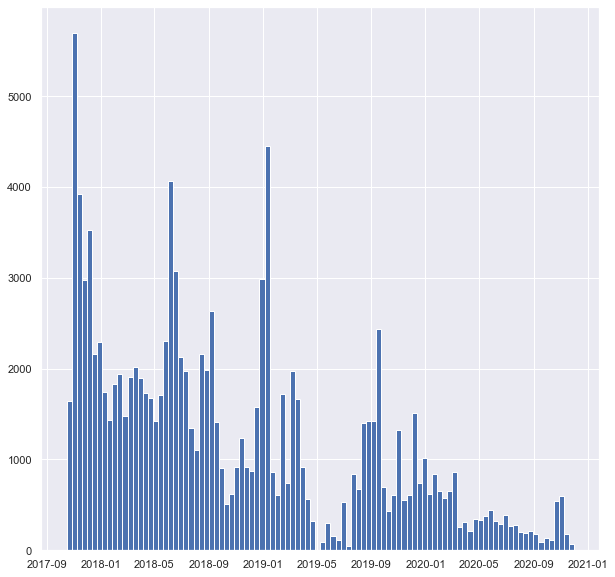

In [25]:
df_datetime.hist(figsize=(10,10), bins=100)
plt.show()

In [26]:
table = dict(sorted(table.items(), key=lambda item: item[1], reverse=True))
Counter(table).most_common(10)

[('banislam', 28780),
 ('bansharia', 13500),
 ('islamistheproblem', 8704),
 ('islam', 6305),
 ('islamexposed', 6135),
 ('muslim', 5480),
 ('religionofpeace', 4469),
 ('uk', 4398),
 ('maga', 4156),
 ('bansharialaw', 4006)]

Create a new dataframe for the bar chart race with an index created on the date and the `entities` column as one of the columns in the dataframe, that holds the hashtags in them

In [27]:
new_df = df.copy()
new_df['date'] = pd.to_datetime(new_df['created_at']).dt.date
new_df.index = new_df['date']
new_df = new_df[['entities']]
new_df.head()

,entities
date,
2017-10-22,"{""hashtags"":[{""text"":""BanIslam"",""indices"":[93,..."
2017-10-22,"{""hashtags"":[{""text"":""muslim"",""indices"":[16,23..."
2017-10-22,"{""hashtags"":[{""text"":""Raqqa"",""indices"":[37,43]..."
2017-10-22,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
2017-10-22,"{""hashtags"":[{""text"":""RT"",""indices"":[51,54]},{..."


In [28]:
datetime_dict = defaultdict(lambda: defaultdict(dict))

def get_counts(entity):
    table = defaultdict(int)
    test = json.loads(entity)
    for x in test['hashtags']:
        table[x['text'].lower()] += 1
    return table
    
for idx, row in tqdm(new_df.iterrows()):
    datetime_dict[idx] = dict(Counter(datetime_dict[idx]) + Counter(get_counts(row['entities'])))

119019it [00:39, 2996.13it/s]


<a id=7.2></a>
### 7.2 Video

The bar chart race video shows some pretty revealing revelations. Most of the islamophobic sentiments have the hashtag #banIslam in them, while as the rest of the hashtags seems to influx as time goes on. Furthermore, another pattern is how the frequency of the tweets start to slow down as time goes on, showing that twitter seems to be hampering down on racial charge tweets as time goes on.

In [29]:
# Renders a 5 second video
'''
df_bar_chart_race = pd.DataFrame.from_dict(datetime_dict,orient='index').fillna(value=0).cumsum()
bcr.bar_chart_race(df = df_bar_chart_race.head(), 
                    n_bars=5, 
                    title = "Popular Hashtags (2017-2021)", 
                    period_length=250,
                    bar_kwargs={'alpha': .7},
                    bar_label_size=7)
'''

'\ndf_bar_chart_race = pd.DataFrame.from_dict(datetime_dict,orient=\'index\').fillna(value=0).cumsum()\nbcr.bar_chart_race(df = df_bar_chart_race.head(), \n                    n_bars=5, \n                    title = "Popular Hashtags (2017-2021)", \n                    period_length=250,\n                    bar_kwargs={\'alpha\': .7},\n                    bar_label_size=7)\n'

<video controls src="hashtag_bcr.mp4" />

<a id=8></a>
## 8. Live Tweet Flagging

This classification model is in the beginning phases, but through simply passing in the most popular hashtags found in the 2 datasets given to us, I am able to flag tweets in live time (or upto a given date), and it is very evident that racially charged tweets are still very prevelant in our society. Through some more NLP on the classification, I hope to flag down tweets at a higher and more efficient rate than the flagging I am doing right now. This live flagging is simply a tool to monitor all the analysis we have provided above that help identify the problem. 

<a id=8.1></a>
### 8.1 Classification

In [30]:
# grab the hashtags we want to track
table = defaultdict(int)

for entity in df['entities']:
    test = json.loads(entity)
    for x in test['hashtags']:
            table[x['text'].lower()] += 1

table = Counter(table)
table = dict(table.most_common(100))

# Remove hashtags that won't hold relevance in flagging
remove  = ['islam', 'muslim', 'religionofpeace', 'uk', 'maga', 'britain', 'muslims', 'buildthewall', 'jihad', 'americafirst', 'religionbeliefs', 'patriotic', 'america', 'wakeupamerica', 'islamic', 'rt', 'stopcarnage', 'pvv', 'kag', 'breaking', 'makedclisten', 'christian',
'educateyourselfonislam', 'tcot', 'terror','freetommy', 'allah', 'migrant', 'usa', 'trump2020', 'travelban', 'us', 'freetommyrobinson', 'rape', 'immigrationreform', 'bannogozones', 'france', 'lilbulli', 'germany','draintheswamp', 'canada', 'europe','cspi','pakistan','trump','veterans', 'trumptrain', 'iran', 'bancair','ramadan', 'closernation','walkaway', 'tocatchathief', 'minnesota', 'wwg1wga', 'potus', 'hamas', 'quran', 'trudeaumustgo', 'murder','ovc16', 'sweden', 'christians',
'police', 'israel', 'isis']
[table.pop(key) for key in remove]
Counter(table).most_common(15)

[('banislam', 28780),
 ('bansharia', 13500),
 ('islamistheproblem', 8704),
 ('islamexposed', 6135),
 ('bansharialaw', 4006),
 ('stopislam', 2660),
 ('rapejihad', 1096),
 ('nosharia', 1051),
 ('sharialaw', 908),
 ('billwarnerphd', 838),
 ('sharia', 827),
 ('cair', 814),
 ('islamicstate', 801),
 ('endislam', 716),
 ('qanon', 651)]

In [31]:
string = " OR ".join(list(table.keys())[:10])
print(string)

banislam OR bansharia OR islamistheproblem OR islamexposed OR bansharialaw OR stopislam OR rapejihad OR nosharia OR sharialaw OR billwarnerphd


<a id=8.2></a>
### 8.2 Live Tweets

Notice how recent these tweets are, through some further digging, I was able to get the location of some of the users, creating a hypothesis that some of these users may be bots with the minimal amount of data associated with the username.

In [33]:
# Configure
c = twint.Config()
c = twint.Config()
c.Search = string
c.Since = '2021-02-13'
c.Limit = 100
c.Store_csv = True
c.Output = 'twitter2.csv'

# Run
twint.run.Search(c)

RuntimeError: This event loop is already running

1363018547807588354 2021-02-20 01:52:00 -0500 <FrontSocial> @Swen_2017 @Nigel_Farage @AlohaHa59067534 C'est ça, vive le mondialisme islamo-collabo !💩  #Grandremplacement #migrants #DefendEurope #Remigration #StopIslam #FrontSocial #RIC  https://t.co/YxcDHF5bkc
1363005304422694914 2021-02-20 00:59:22 -0500 <AllGoneTomorrow> @AriBerman @SusanSarandon THIS IS WHAT I'M ON ABOUT ⚠  #NoDominionism❗ #NoSharia❗ #SeparateChurchAndState❗ #FreedomFromReligion❕❗❕⚠‼
1362989659480023040 2021-02-19 23:57:12 -0500 <FrontSocial> @suivezlecoq C'est à cause d'eux et de gens comme vous que nous ne pouvons plus tuer le Cochon !🇫🇷😠  #Grandremplacement #migrants #DefendEurope #Remigration #StopIslam #FrontSocial #RIC   https://t.co/cPt6WMz2iR
1362984633546256386 2021-02-19 23:37:14 -0500 <FrontSocial> @PoliceNat44 Vous faites de la peine... #ProtectionAnimale 😏  Par contre pour les Français, eux ils peuvent se faire remplacer et massacrer au couteau , c'est la mode hein ?🤔  #Grandremplacement #migrants #Defe

1362857829066018820 2021-02-19 15:13:21 -0500 <FrontSocial> @F_Desouche Traduction: #Présidentielle2022 : #Hidalgo a «très peur» pour sa peau si les Français arrivaient au pouvoir !😁  #Grandremplacement #migrants #DefendEurope #Remigration #StopIslam #FrontSocial #RIC   https://t.co/FIQNwNDWwb
1362857169994063874 2021-02-19 15:10:44 -0500 <FrontSocial> @F_Desouche #Remigration immédiate des #migrants et il faut détruire ces navires de traites humaines pour le #GrandRemplacement !😠  #SoutienGenerationIdentitaire #ManifGenerationID  #DefendEurope #Remigration #StopIslam #FrontSocial #RIC   https://t.co/hBNyNejUbu
1362855758182952962 2021-02-19 15:05:08 -0500 <FrontSocial> @F_Desouche Tiens les Marocains aussi ne veulent pas êtres envahis, mais là ce n'est pas raciste ?🤔😁  Qu'ils retournent chez eux et les vaches seront bien gardées !  #Grandremplacement #migrants #DefendEurope #Remigration #StopIslam #FrontSocial #RIC   https://t.co/zCJpIFJ8f0
1362852996367994881 2021-02-19 14:54:09 -050

1362791245756653569 2021-02-19 10:48:47 -0500 <FrontSocial> @kevinbossuet Ah ah ah, quand tu découvre ce qu'est #LFI La France Islamique !⤵️ 🤭😂🤣  #Grandremplacement #migrants #DefendEurope #Remigration #StopIslam #FrontSocial #RIC   https://t.co/khWalvKw7g
1362787854968061958 2021-02-19 10:35:18 -0500 <FrontSocial> @AnkouJl @Andrgilles1 @F_Desouche Ah ça, pour avoir les pieds dans la merde, à croire que les Français adorent ça...💩🤥  #Grandremplacement #migrants #DefendEurope #Remigration #StopIslam #FrontSocial #RIC  https://t.co/2idI5Gledr
1362784635789443079 2021-02-19 10:22:31 -0500 <marilynnefriedm> Shameful but not unexpected: in their ongoing bigotry towards (through low expectations of) #Palestinians, @AP @washingtonpost, @latimes blame #Israel when #Hamas Deny #WomensRights. #sharialaw  https://t.co/lFcAiqP8Rq @honestreporting
1362784038189232137 2021-02-19 10:20:08 -0500 <FrontSocial> @jfpoisson78 @VotezPoisson Mais le #GrandRemplacement n’existe pas, l'immigration apporte de 

In [34]:
df_twitter = pd.read_csv('./twitter2.csv')
df_twitter.head()

counter = 0
for index, row in (df_twitter.iterrows()):
    if df_twitter['date'][index] == "2021-02-19" and counter  <20:
        print(df_twitter['created_at'][index] + ' ' + df_twitter['username'][index] + ': ' + df_twitter['tweet'][index] + '\n')
        counter += 1

2021-02-19 23:57:12 Eastern Standard Time frontsocial: @suivezlecoq C'est à cause d'eux et de gens comme vous que nous ne pouvons plus tuer le Cochon !🇫🇷😠  #Grandremplacement #migrants #DefendEurope #Remigration #StopIslam #FrontSocial #RIC   https://t.co/cPt6WMz2iR

2021-02-19 23:37:14 Eastern Standard Time frontsocial: @PoliceNat44 Vous faites de la peine... #ProtectionAnimale 😏  Par contre pour les Français, eux ils peuvent se faire remplacer et massacrer au couteau , c'est la mode hein ?🤔  #Grandremplacement #migrants #DefendEurope #Remigration #StopIslam #FrontSocial #RIC    https://t.co/cPt6WMz2iR

2021-02-19 23:10:52 Eastern Standard Time frontsocial: @BultotPatrice Ah bon, alors là, c'est la meilleur, la France n'est pas une poubelle depuis plus de 40 ans ?!🚮🤔🤭😂  #Grandremplacement #migrants #DefendEurope #Remigration #StopIslam #FrontSocial #RIC    https://t.co/pvPGx3ZpSf

2021-02-19 23:05:26 Eastern Standard Time frontsocial: @AnneFarmer65 La faute au réchauffement climatique

<a id=9></a>
## 9. Twitter Heatmap

In [35]:
place_df = df[df["place"].notna()].astype('str')
place_df = place_df["place"]
print(place_df)

94       {"id":"1d68da80ca90416d","url":"https://api.tw...
206      {"id":"53cef5332ac9d7d0","url":"https://api.tw...
638      {"id":"f632697d33274211","url":"https://api.tw...
642      {"id":"5635c19c2b5078d1","url":"https://api.tw...
997      {"id":"a81f9ed24c15d6af","url":"https://api.tw...
                               ...                        
73381    {"id":"2a8a74486cd0d519","url":"https://api.tw...
73915    {"id":"243cc16f6417a167","url":"https://api.tw...
73972    {"id":"8e9665cec9370f0f","url":"https://api.tw...
74221    {"id":"67d92742f1ebf307","url":"https://api.tw...
74229    {"id":"ad0818e2fb208dde","url":"https://api.tw...
Name: place, Length: 675, dtype: object


In [36]:
places = place_df.apply(json.loads).apply(pd.Series)
places['full_name'] = places['full_name'].str.replace(', USA', '')
places['location'] = places['full_name'] + ", " + places['country']
places.head()

,id,url,place_type,name,full_name,country_code,country,contained_within,bounding_box,attributes,location
94,1d68da80ca90416d,https://api.twitter.com/1.1/geo/id/1d68da80ca9...,city,Kawartha Lakes,"Kawartha Lakes, Ontario",CA,Canada,[],"{'type': 'Polygon', 'coordinates': [[[-79.2086...",{},"Kawartha Lakes, Ontario, Canada"
206,53cef5332ac9d7d0,https://api.twitter.com/1.1/geo/id/53cef5332ac...,city,Waunfawr,"Waunfawr, Wales",GB,United Kingdom,[],"{'type': 'Polygon', 'coordinates': [[[-4.21700...",{},"Waunfawr, Wales, United Kingdom"
638,f632697d33274211,https://api.twitter.com/1.1/geo/id/f632697d332...,city,Mount Airy,"Mount Airy, MD",US,United States,[],"{'type': 'Polygon', 'coordinates': [[[-77.1957...",{},"Mount Airy, MD, United States"
642,5635c19c2b5078d1,https://api.twitter.com/1.1/geo/id/5635c19c2b5...,admin,Virginia,Virginia,US,United States,[],"{'type': 'Polygon', 'coordinates': [[[-83.6752...",{},"Virginia, United States"
997,a81f9ed24c15d6af,https://api.twitter.com/1.1/geo/id/a81f9ed24c1...,city,Grand Rapids,"Grand Rapids, MI",US,United States,[],"{'type': 'Polygon', 'coordinates': [[[-85.7514...",{},"Grand Rapids, MI, United States"


<a id=9.1></a>
### 9.1 Dot Map

In [37]:
locator = Nominatim(user_agent='myGeocoder')
m = folium.Map(location=[20,0], zoom_start=2)
data = []
for index, row in places.iterrows():
    location = locator.geocode(row['location'])
    if (location == None):
        location = locator.geocode(row['country'])
        
    data.append([location.latitude, location.longitude, 1])
    
    folium.Circle(
        radius=400,
        location=[location.latitude, location.longitude],
        popup=row["name"],
        color="crimson",
        fill=False,
    ).add_to(m)
places_copy = pd.DataFrame(data, columns=['latitude', 'longitude', 'count'])
m.save('50kdotmap.html')
m

<a id=9.2></a>
### 9.2 Heat Map

In [38]:
n = folium.Map(location=[20,0], zoom_start=2)
HeatMap(data=places_copy[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=10, max_zoom=10).add_to(n)
n.save('50kheatmap.html')
n

In [39]:
total_entries = len(df.index)
print(len(df.index))
print(len(places.index))
location_entries = len(places.index)
print(str(100*(location_entries/total_entries)) + "% of total entries have location information available.")
#Studies demonstrate that approximately 0.85% of tweets are geotagged: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4636345/"
#Study looked at a sample of 113 million tweets. As such, we can be 99% confident that that this is a statistically significant difference
#What is making this percentage so low? Most likely, there is an abundance of bots posting negative about Islam

119019
675
0.567136339576034% of total entries have location information available.


<a id=10></a>
## 10. Conclusion

We were able to use this data to discover a lot of relationships:
- Relationships between different users through mentions
- The relationship between users and where they are tweeting from

The tools we presented allow activists to take data-driven action in reaching out to specific users in specific regions to efficiently manage their efforts in combating Islamophobia.


[Back to Top](#top)